In [1]:
from importlib import reload
from src import parsing
from src import model_path
from src import models_path
from src import model_goal
from src import models_goal
from src import model_interface
from src import visualization
from src import util
from src import config
reload(parsing)
reload(model_path)
reload(models_path)
reload(model_goal)
reload(models_goal)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# file used for evaluating the atc dataset
file_path = "medium_aa.csv"

In [4]:
## load raw data into pandas
## modified from parsing.py:
df = pd.read_csv(f"data/{file_path}", names=["time", "id", "x", "y", "z", "velocity", "motion_angle", "facing_angle"])
df = df.drop(columns=['z', 'velocity', 'motion_angle', 'facing_angle'])
df['time'] = pd.to_datetime(df['time'], unit='s')

Min -41020, Max 48051, Mean 270.2975155, Std 19186.293111789735


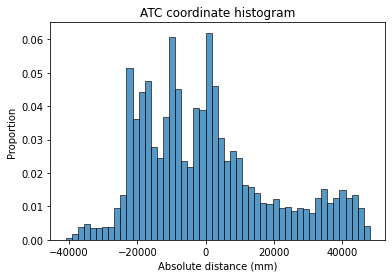

In [8]:
# for this we are only interested in the x and y columns
# combine these in a single 1D numpy array
raw_data = df.loc[:, ['x', 'y']].to_numpy().flatten()
plt.xlabel('Absolute distance (mm)')
plt.title('ATC coordinate histogram')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_absolute.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

In [9]:
# scale df
df['x'] = df['x'] / config.SCALING_FACTOR
df['y'] = df['y'] / config.SCALING_FACTOR

Min -4.102, Max 4.8051, Mean 0.02702975155000001, Std 1.9186293111789734


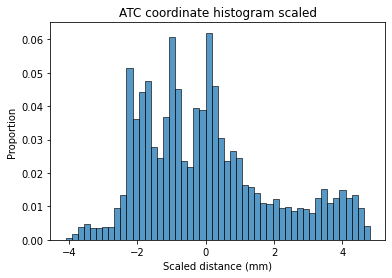

In [15]:
raw_data = df.loc[:, ['x', 'y']].to_numpy().flatten()

plt.xlabel('Scaled distance (mm)')
plt.title('ATC coordinate histogram scaled')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_absolute_relative.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

In [6]:
# load testing data and format it for the model
train_data, eval_data, test_data = parsing.parse_atc_day(file_path, train_ratio=0.9, eval_ratio=0.1)

100%|██████████| 1224/1224 [00:05<00:00, 215.29it/s]


1224 unique ids found. Generated 37393 sequences total from 659 trajectories.
Skipped 503 trajectories.
        353 too short
        150 frequency issues (like gaps)
    
Skipped 137 sequences (0.366%) because of abnormally high absolute value after normalization
Dividing 659 human trajectories: 593 training, 66 eval, 0 test
train (33719, 50, 2) float32 (33719, 25) float32 (33719, 50, 2) float32
eval (3674, 50, 2) float32 (3674, 25) float32 (3674, 50, 2) float32


Min -0.9978416058039066, Max 0.9985649944158445, Mean 5.180189878067488e-06, Std 0.1726481259448845


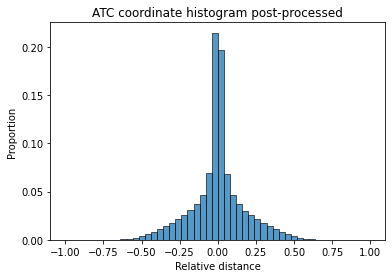

In [14]:
raw_data_x = train_data[0].flatten()
raw_data_y = train_data[2].flatten()
raw_data = np.concatenate((raw_data_x, raw_data_y))

plt.xlabel('Relative distance')
plt.title('ATC coordinate histogram post-processed')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_postprocessed.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

<AxesSubplot:ylabel='Proportion'>

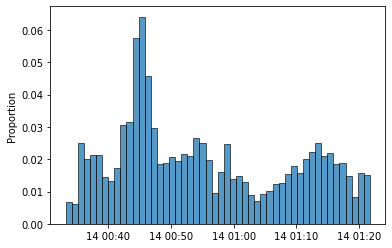

In [35]:
raw_data = df.loc[:, ['time']].to_numpy().flatten()
seaborn.histplot(data=raw_data, bins=50, stat='proportion')

[12.920473 12.920474 12.640043 12.640043 12.595203 12.595204 12.496862
 12.496862 12.099007 12.099007] (33719,) (33719, 50, 2)


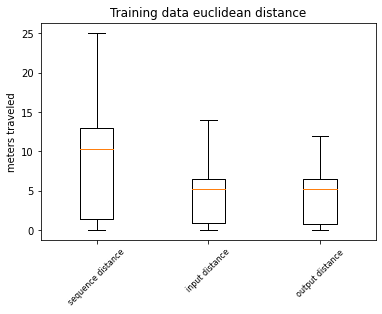

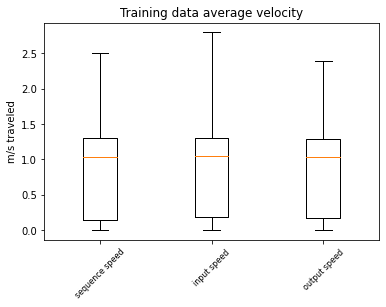

In [26]:
def calculate_euclidean_distance(distance_arr):
    # total distance traveled euclidean
    dist = distance_arr ** 2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    # scale to m
    dist = dist * 10
    return dist


# calculate and plot distances
input_path = train_data[0]
output_path = train_data[2]

# total distance traveled
distances_total = output_path[:, -1] - input_path[:, 0]
distances_total = calculate_euclidean_distance(distances_total)

# distance traveled for input
distance_input = input_path[:, -1] - input_path[:, 0]
distance_input = calculate_euclidean_distance(distance_input)

# distance traveled output
distance_output = output_path[:, -1] - output_path[:, 0]
distance_output = calculate_euclidean_distance(distance_output)

print(distances_total[:10], distances_total.shape, input_path.shape)

fig, ax = plt.subplots()
plt.title("Training data euclidean distance")
plt.boxplot( [distances_total, distance_input, distance_output] )
plt.ylabel("meters traveled")
ax.set_xticklabels(["sequence distance", "input distance", "output distance"], rotation=45, fontsize=8)
plt.savefig("figures/boxplot_data_distances.pdf", bbox_inches = "tight")
plt.show()

speed_total = distances_total / 10
speed_input = distance_input / 5
speed_output = distance_output / 5

fig, ax = plt.subplots()
plt.title("Training data average velocity")
plt.boxplot( [speed_total, speed_input, speed_output] )
plt.ylabel("m/s traveled")
ax.set_xticklabels(["sequence speed", "input speed", "output speed"], rotation=45, fontsize=8)
plt.savefig("figures/boxplot_data_speed.pdf", bbox_inches = "tight")
plt.show()

[9383900, 9465000, 9584200]


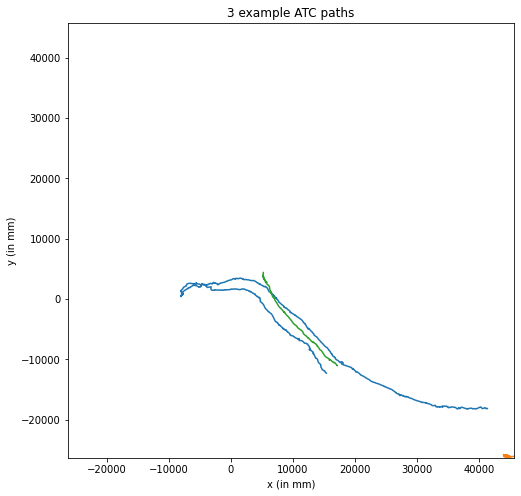

In [38]:
import random

ids = df.id.unique()

fig, ax = plt.subplots()


val_range = [0, +10000]

k = 3
chosen_ids = random.choices(ids, k=k)
plt.title(f"{k} example ATC paths")

print(chosen_ids)

for name_id in chosen_ids:
    id_frame = df[df["id"] == name_id]

    x_vals = id_frame['x'].to_numpy()
    y_vals = id_frame['y'].to_numpy()

    min_val = min(x_vals.min(), y_vals.min())
    if min_val < val_range[0]:
        val_range[0] = min_val
    max_val = max(x_vals.max(), y_vals.max())
    if max_val > val_range[1]:
        val_range[1] = max_val

    plt.plot(x_vals, y_vals)

# plt.boxplot( [distances_total, distance_input, distance_output] )
plt.xlabel("x (in mm)")
plt.ylabel("y (in mm)")
plt.xlim(val_range)
plt.ylim(val_range)
fig.set_size_inches(8.0, 8.0)
plt.savefig(f"figures/{k}_random_atc_examples.pdf", bbox_inches = "tight")

# ax.set_xticklabels(["sequence distance", "input distance", "output distance"], rotation=45, fontsize=8)
# plt.savefig("figures/boxplot_data_distances.pdf", bbox_inches = "tight")
plt.show()